In [1]:
from netCDF4 import Dataset
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pycurrents.codas import DB
import glob
import os

In [2]:
# 1. Include an argument to choose which features to extract from database and nc files. 
# 2. 

In [3]:
# retrns the absolute path of all subdirectories in a give directory.
# this is similar to useing the nc finder function but for directories. 
def list_subdirectories(directory):
    # List to store absolute paths of subdirectories
    subdirectories = []
    
    # Walk through the directory and collect all subdirectories
    for root, dirs, _ in os.walk(directory):
        for subdir in dirs:
            # Append the absolute path of each subdirectory
            subdirectories.append(os.path.abspath(os.path.join(root, subdir)))
    
    return subdirectories

def find_dbname(directory):
    # Search for any file ending in .list in the specified directory
    list_files = glob.glob(os.path.join(directory, '*.lst'))
    
    # If no .list files are found, return None
    if not list_files:
        return None
    
    # Get the first match (assuming there might be only one or you want the first one)
    file_path = list_files[0]
    
    # Extract the filename without path and split to get the word before '.list'
    file_name = os.path.basename(file_path)
    word_before_list = file_name.rsplit('.lst', 1)[0]
    
    return word_before_list

### Load in the training data from data base. 
def db_load(dir = "/home/jamie/cruise_processing/falkortoo/FKt240817/wh300/adcpdb"):
    tag = find_dbname(dir)
    dbname = dir + "/" + tag
    db = DB(dbname)
    depth = db.get_variable('DEPTH')
    amp = db.get_variable('AMP_SOUND_SCAT') # ie signal return
    # sw = db.get_variable('SPECTRAL_WIDTH') # ie correlation
    pg = db.get_variable('PERCENT_GOOD') # ie correlation
    mask = db.get_variable('PROFILE_FLAGS')
    err = db.get_variable('ERROR_VEL')
    # error velocity sounds nice too

    features = np.stack([amp.flatten(), depth.flatten(), pg.flatten(), err.flatten()], axis=1) # depth.flatten()
    predictor =  mask.flatten()
    
    return(features, predictor)

### Load in the training data from nc files. 
def nc_load(dir = "/home/jamie/cruise_processing/falkortoo/FKt240817/wh300/wh300.nc"):
    ### Load in the test data u and v for plotting. 
    file_id = Dataset(dir)
    pg = file_id.variables["pg"][:]
    amp = file_id.variables["amp"][:]
    mask = file_id.variables["pflag"][:]
    depth = file_id.variables["depth"][:]
    file_id.close()

    features = np.stack([amp.flatten(), depth.flatten(), pg.flatten()], axis=1) # depth.flatten()
    predictor =  mask.flatten()
    # error velocity sounds nice too
    return(features, predictor)

# funtion for listing all nc files in a directory with there absolute path. 
def list_nc_files(directory):
    nc_files = glob.glob(os.path.join(directory, '**', '*.nc'), recursive=True)
    # Convert to absolute paths
    nc_files = [os.path.abspath(path) for path in nc_files]
    return nc_files

def bulkload_db(dir = "/home/jamie/projects/flag_model/data/dbdirs"):
    # load train data
    # loop through the list using nc_loader and put output into an empty list then compress the list. 
    dbfiles = list_subdirectories(dir)
    X = list()
    Y = list()
    for i in range(0, len(dbfiles)):
        file = dbfiles[i]
        param, predic = db_load(file)
        X.append(param)
        Y.append(predic)
    features = np.vstack(X)
    predictor = np.hstack(Y)
    return(features, predictor)

def bulkload_nc(dir = "/home/jamie/projects/flag_model/data/ncfiles"):
    # load train data
    # loop through the list using nc_loader and put output into an empty list then compress the list. 
    dbfiles = list_nc_files(dir)
    X = list()
    Y = list()
    for i in range(0, len(dbfiles)):
        file = dbfiles[i]
        param, predic = nc_load(file)
        X.append(param)
        Y.append(predic)
    features = np.vstack(X)
    predictor = np.hstack(Y)
    predictor = predictor.flatten()
    return(features, predictor)

def what_flags(x, y, arg = [0, 1, 2, 3, 4, 5, 6, 7]):
    # Only train on the good stuf. 
    idx = np.isin(y, arg)
    usr_mask = idx.flatten()
    x = x[idx, :]
    # make all masks 0 or 1. Needed if other flags are used. 
    y = y[usr_mask]
    y[y != 0] = 1
    return(x, y)

In [4]:
features, predictor = bulkload_db(dir = "/home/jamie/projects/flag_model/data/dbdirs")
features, predictor = what_flags(features, predictor, arg = [0, 1])

# run the model
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(train_cruise)
X_train, X_test, y_train, y_test = train_test_split(features, predictor, test_size=0.7, random_state=42, stratify=predictor)
model = LogisticRegression(max_iter=7000)  
model.fit(X_train, y_train)

LogisticRegression(max_iter=7000)

In [6]:
### Load in the test data u for plotting. 
file_id = Dataset('/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/contour/wh300.nc')
u = file_id.variables["v"][:]
file_id.close()
s = u.shape

# laod test data for the model.
features_test, predictor_test = db_load("/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/adcpdb")
new_y_pred = model.predict(features_test) 
# put humpoty dumpty back together again
pred_flags = new_y_pred.reshape(s[0], s[1]) 
predictor_test = predictor_test.reshape(s[0], s[1]) 
# predictor_test[predictor_test != 0] = 1

In [7]:
# Everything that isnt unflagged or manually flagged is now identified. 
auto_flagged = predictor_test.copy()
bin_flag = predictor_test.copy()

# subset only the algorithm falgs
arg = [0, 1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor_test, arg)
auto_flagged[~idx] = 1
auto_flagged[idx] = 0

# subset only the manualy edited falgs
arg = [1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor_test, arg)
bin_flag[~idx] = 0

# subset only the all the flags. 
all_flag = predictor_test.copy()
all_flag[all_flag != 0] = 1

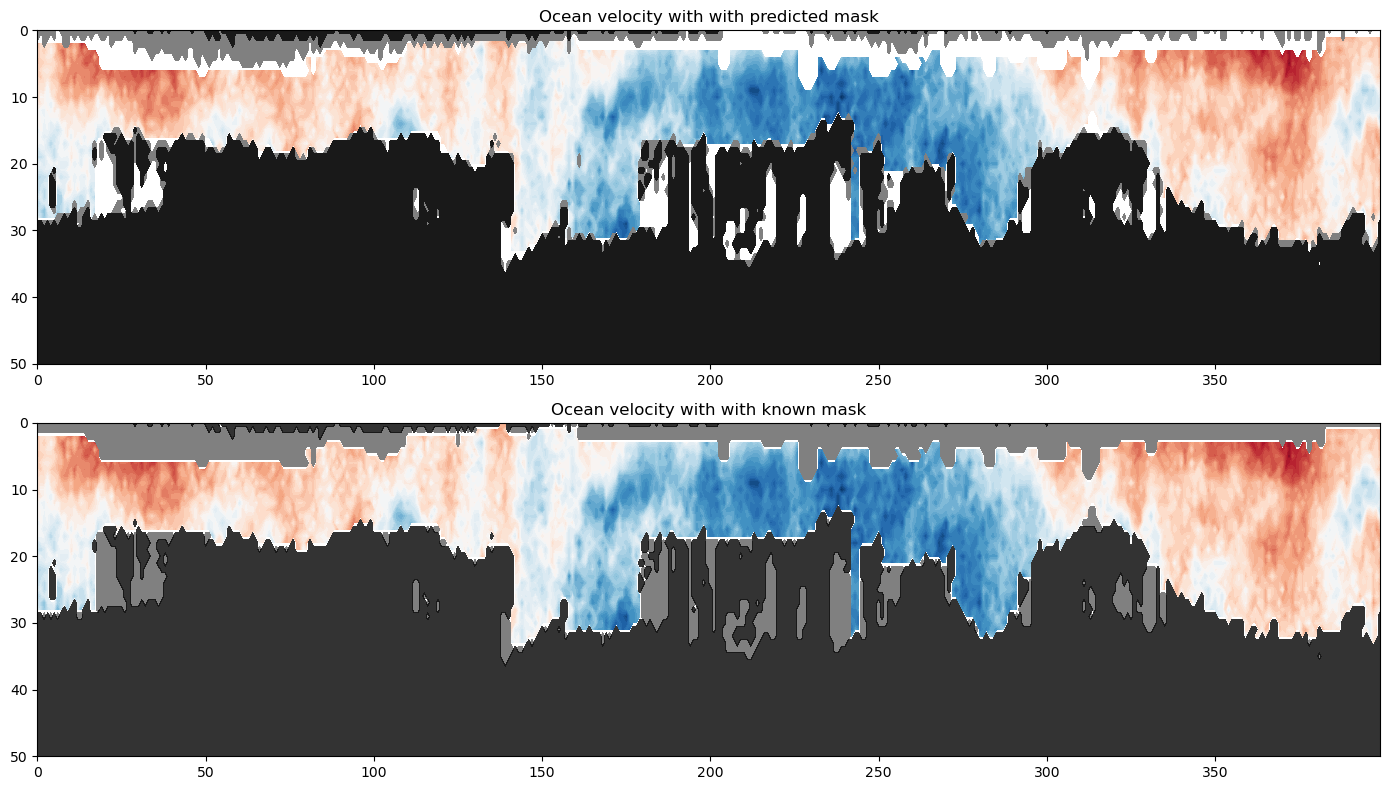

In [8]:
idx = range(3400, 3800)

# Define the feature array and predicted mask array
feature = u # n by m array
predicted_mask = pred_flags  # n by m array

fig, ax = plt.subplots(2, 1, figsize=(14, 8))
contour1 = ax[0].contourf(feature.T[:, idx], cmap='RdBu', levels=50)
# contour1.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[0].contourf(predicted_mask.T[:, idx], levels=[0.5, 1], colors='grey', alpha=1)
ax[0].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.8)
ax[0].set_title('Ocean velocity with with predicted mask')
ax[0].set_ylim(50, 0)

contour2 = ax[1].contourf(feature.T[:, idx], cmap='RdBu',levels=50)
# contour2.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[1].contourf(bin_flag.T[:, idx], levels=[0.5, 1], colors='grey', alpha=1)
ax[1].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.8)
ax[1].set_title('Ocean velocity with with known mask')
ax[1].set_ylim(50, 0)
# fig.colorbar(contour2, ax=ax, orientation='vertical', label="ocean velocity")
plt.tight_layout()
plt.show()

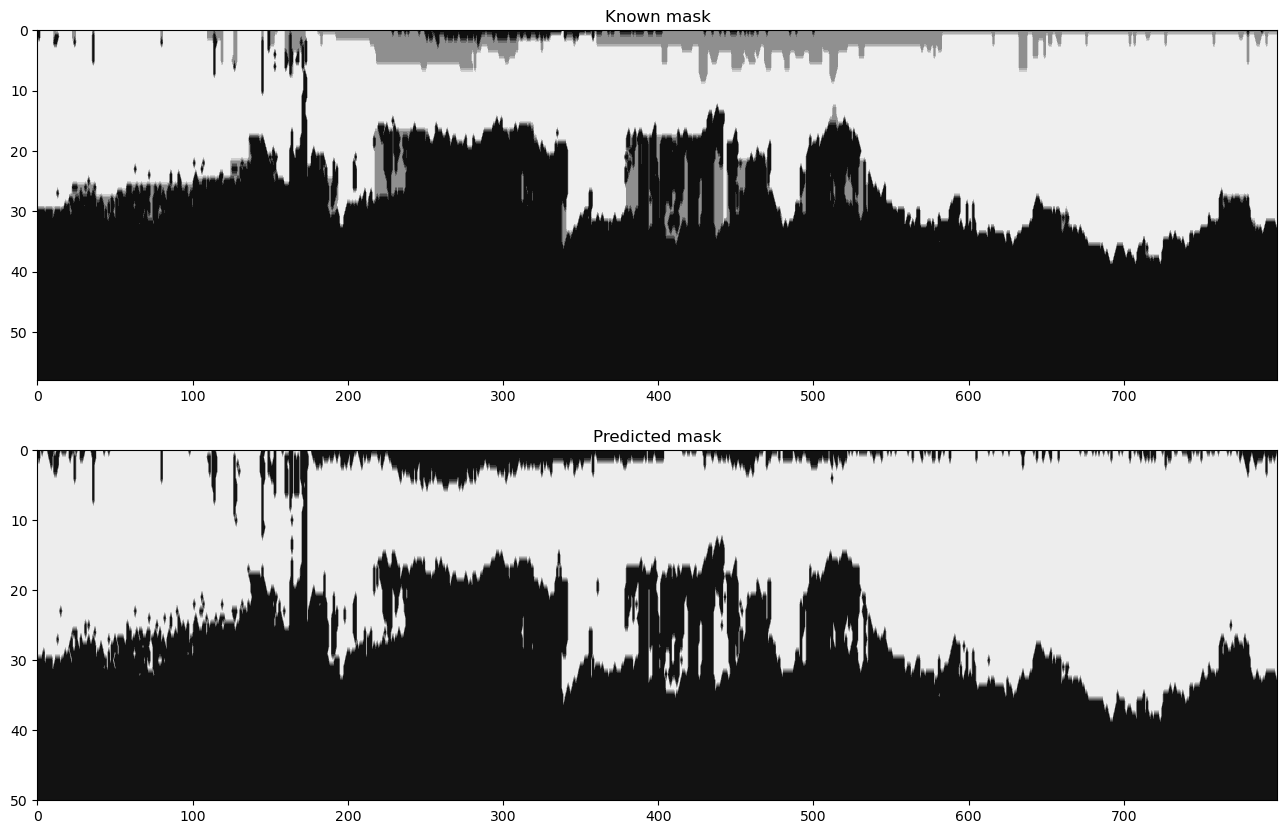

In [ ]:
idx = range(3200, 4000)

fig, ax = plt.subplots(2, 1, figsize = (16, 10))
ax[0].contourf(predictor_test.T[:, idx], cmap='binary') 
ax[0].set_ylim(58, 0)
ax[0].set_title('Known mask')
ax[1].contourf(pred_flags.T[:, idx], cmap='binary') 
ax[1].set_ylim(50, 0)
ax[1].set_title('Predicted mask');